In [11]:
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
from numpy import linalg as LA
import numpy as np
import random
import glob
import os

In [76]:
class PCA:
    
    def eigenize(self, X, k=None):
        C = np.cov(X)
        W, V = LA.eig(C)
        idx = W.argsort()[::-1]
        U = V[idx[:k]].dot(X)
        return U

    def view_eigenfaces(self, m, n):
        v = self.V
        for i in range(min(m*n, len(v))):
            plt.subplot(m, n, i+1)
            im = v[i].reshape(shape)
            plt.axis('off')
            plt.imshow(im, cmap='gray')
        plt.suptitle('Eigenfaces')
        plt.show()

    def get_signatures(self, X):
        V, M = self.V, self.M
        if len(X.shape) > 2:
            X = np.reshape(X, (X.shape[0], X.shape[1]*X.shape[2]))
        return V.dot(X.T).T
        
    def train(self, X, Y, k=15):
        self.M = np.mean(X, axis=0)
        self.X = X - self.M
        self.Y = Y
        self.V = self.eigenize(X, k=k)
        self.signatures = self.get_signatures(self.X)
        
    def predict(self, X, thresh=None):
        A = self.signatures
        X = X - self.M
        signs = self.get_signatures(X)
        YY = []
        for x in signs:
            mini, idx = None, None
            for i,a in enumerate(A):
                curr = LA.norm(x-a)
                if mini == None or curr < mini:
                    mini = curr
                    idx = i
            YY.append([self.Y[idx], mini] if not thresh or mini <= thresh else (None, mini))
        return YY

In [57]:
def load_data(folder, people=None, poses=None, seed=None):
    random.seed(seed)
    labels = [f.name for f in os.scandir(folder) if f.is_dir()]
    people = people if people else len(labels)
    labels = random.sample(labels, people)
    X, Y, Xt, Yt = [], [], [], []
    for label in labels:
        files = glob.glob(f'{folder}/{label}/*')
        poses = poses if poses else len(files)
        train_files = random.sample(files, poses)
        test_files = list(set(files).difference(set(train_files)))
        assert len(train_files) + len(test_files) == len(files)
        for file in train_files:
            image = plt.imread(file)
            shape = image.shape
            image = image.flatten()
            X.append(image)
            Y.append(label)
        for file in test_files:
            image = plt.imread(file)
            shape = image.shape
            image = image.flatten()
            Xt.append(image)
            Yt.append(label)
    return np.array(X), np.array(Y), np.array(Xt), np.array(Yt), shape

In [72]:
def calc_accuracy(YY, test_y):
    correct, wrong, none = 0, 0, 0
    for idx in range(len(YY)):
        res, mini = YY[idx]
        if not res:
            none += 1
        elif res != test_y[idx]:
            wrong += 1
        else:
            correct += 1
    acc = correct/(wrong+none+correct)
    return acc, correct, wrong, none

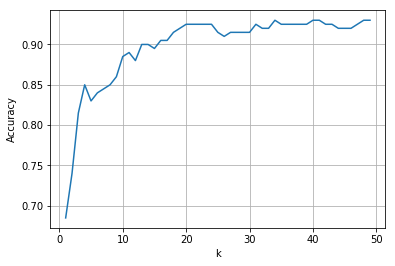

Best at k = 34 (0.93)


In [107]:
train_x, train_y, test_x, test_y, shape = load_data('orl_faces', people=20, poses=6, seed=42)
model = PCA()
test_x, test_y, _, _, shape = load_data('orl_faces', people=20, poses=None, seed=42)
accs = []
k_vals = range(1, 50, 1)
for k in tqdm(k_vals):
    model.train(train_x, train_y, k)
    YY = model.predict(test_x)
    acc, correct, wrong, none = calc_accuracy(YY, test_y)
    accs.append(acc)
plt.plot(k_vals, accs)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.grid()
plt.show()
k = k_vals[accs.index(max(accs))]
print(f'Best at k = {k} ({max(accs)})')

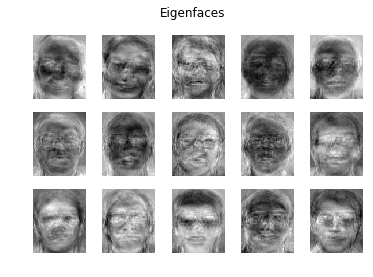

In [108]:
model.train(train_x, train_y, k)
model.view_eigenfaces(3, 5)

In [109]:
YY = model.predict(test_x)
acc, correct, wrong, none = calc_accuracy(YY, test_y)
print(f'Correct: {correct}')
print(f'Wrong: {wrong+none} ({wrong} + {none})')
print(f'Accuracy: {correct/(correct+wrong+none)}')

Correct: 186
Wrong: 14 (14 + 0)
Accuracy: 0.93
